Marketing companies want to run successful campaigns, but the market is complex and several options can work. So normally they tun A/B tests, that is a randomized experimentation process wherein two or more versions of a variable (web page, page element, banner, etc.) are shown to different segments of people at the same time to determine which version leaves the maximum impact and drive business metrics.

The companies are interested in answering two questions:

1) Would the campaign be successful?\
2) If the campaign was successful, how much of that success could be attributed to the ads?

With the second question in mind, we normally do an A/B test. The majority of the people will be exposed to ads (the experimental group). And a small portion of people (the control group) would instead see a Public Service Announcement (PSA) (or nothing) in the exact size and place the ad would normally be.

The idea of the dataset is to analyze the groups, find if the ads were successful, how much the company can make from the ads, and if the difference between the groups is statistically significant.

Data dictionary:

Index: Row index
user id: User ID (unique)\
test group: If "ad" the person saw the advertisement, if "psa" they only saw the public service announcement\
converted: If a person bought the product then True, else is False\
total ads: Amount of ads seen by person\
most ads day: Day that the person saw the biggest amount of ads\
most ads hour: Hour of day that the person saw the biggest amount of ads

In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import shapiro
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import resample

## Import data / Preprocessing

In [3]:
raw_data = pd.read_csv("marketing_ab.csv")
raw_data

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14
...,...,...,...,...,...,...,...
588096,588096,1278437,ad,False,1,Tuesday,23
588097,588097,1327975,ad,False,1,Tuesday,23
588098,588098,1038442,ad,False,3,Tuesday,23
588099,588099,1496395,ad,False,1,Tuesday,23


<AxesSubplot:>

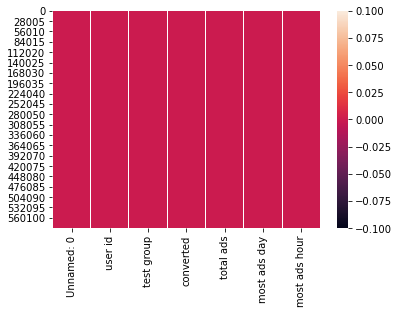

In [4]:
sns.heatmap(raw_data.isnull())

In [5]:
raw_data.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
raw_data.columns = np.array(pd.Series(raw_data.columns).apply(lambda x: x.replace(' ', '_')))

In [7]:
raw_data

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14
...,...,...,...,...,...,...
588096,1278437,ad,False,1,Tuesday,23
588097,1327975,ad,False,1,Tuesday,23
588098,1038442,ad,False,3,Tuesday,23
588099,1496395,ad,False,1,Tuesday,23


In [8]:
raw_data.describe(include = 'all')

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
count,5.881010e+05,588101,588101,588101.000000,588101,588101.000000
unique,NaN,2,2,NaN,7,NaN
top,NaN,ad,False,NaN,Friday,NaN
freq,NaN,564577,573258,NaN,92608,NaN
mean,1.310692e+06,NaN,NaN,24.820876,NaN,14.469061
std,2.022260e+05,NaN,NaN,43.715181,NaN,4.834634
min,9.000000e+05,NaN,NaN,1.000000,NaN,0.000000
25%,1.143190e+06,NaN,NaN,4.000000,NaN,11.000000
50%,1.313725e+06,NaN,NaN,13.000000,NaN,14.000000
75%,1.484088e+06,NaN,NaN,27.000000,NaN,18.000000


In [9]:
pt = pd.pivot_table(raw_data, index='converted', columns='test_group', values='user_id', aggfunc=['count'])
pt

count       
test_group      ad    psa
converted                
False       550154  23104
True         14423    420

In [62]:
x_ad = 14423
x_psa = 420

In [10]:
raw_data.groupby('test_group')['converted'].mean()

test_group
ad     0.025547
psa    0.017854
Name: converted, dtype: float64

In [76]:
p_ad = .025547
p_psa = .017854
p_pooled = raw_data['converted'].mean()
p_pooled

0.02523886203220195

In [49]:
raw_data['test_group'].value_counts()

ad     564577
psa     23524
Name: test_group, dtype: int64

In [50]:
n_ad = 564577
n_psa = 23524

## A/B Test for significance of advertising campaign vesus public service announcement (no advertising) on conversion rate.

#### Before testing: is the sample size large enough? Let's assume 95% confidence, 80% power, .05 minimum detectable effect, and p = .5 as the true proportion for conversion rate is unknown.

In [67]:
def sample_size_proportion(confidence, power, min_effect, p1, p2):
    z = {
        .90 : 1.645,
        .95 : 1.96,
        .99 : 2.575
    }
    b = {
        .7 : .52,
        .8 : .84,
        .9 : 1.28
    } 
    
    z_alpha = z[confidence]
    z_beta = b[power]
    q1=1-p1
    q2=1-p2
    
    sample_size = ((z_alpha + z_beta)**2)*((p1*q1) + (p2*q2))/min_effect**2
    
    return(sample_size)

In [33]:
print(sample_size_proportion(.95,.8,.05,.5,.5))

1567.9999999999995


#### The sample size is definitely large enough. Sanity check: np >= 10, nq >=10

### Hypothesis & Results

H0: There is no difference in conversion rate between the advertising campaign group and the public service announcement group. (p_ad = p_psa).\
Ha: The conversion rate for the advertising campaign is greater than the conversion rate for the public service announcement (p_ad > p_psa).

p_ad (advertising) = .025547, p_psa (psa) = .017854\
n_ad = 564577, n_psa = 23524

In [72]:
def two_prop_z_test(x1, x2, n1, n2, alternative, alpha):
    z_score, p_value = sm.stats.proportions_ztest([x_ad, x_psa], [n_ad, n_psa], alternative='larger')
    if p_value < alpha:
        print("A two proportion z-test generated a p-value of " + str(p_value) + ", therefore we reject the null hypothesis at the alpha = " + str(alpha) + " level of significance.")
    else:
        print("A two proportion z-test generated a p-value of " + str(p_value) + ", therefore we fail to reject the null hypothesis at the alpha = " + str(alpha) + " level of significance.")

In [73]:
two_prop_z_test(x_ad, x_psa, n_ad, n_psa, 'larger', .05)

A two proportion z-test generated a p-value of 8.526403580779863e-14, therefore we reject the null hypothesis at the alpha = 0.05 level of significance.


### Does the number of ads seen differ for those who converted vs those who did not convert?

We will investigate the mean number of ads seen by those who converted, and the mean number of ads seen by those who did not convert. This may provide insight into how much should be spent on advertisements - if volume doesn't matter much, a lot of money can be saved.

H0: There is no difference in the mean number of ads seen by those who converted and the mean number of ads seen by those who did not convert. (u_converted = u_not).\
Ha: The mean number of ads seen for those who did convert is higher than the mean number of ads seen for those who did not convert. (u_converted > u_not).

In [92]:
ads_group = raw_data[raw_data['test_group'] == "ad"]
ads_group

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14
...,...,...,...,...,...,...
588096,1278437,ad,False,1,Tuesday,23
588097,1327975,ad,False,1,Tuesday,23
588098,1038442,ad,False,3,Tuesday,23
588099,1496395,ad,False,1,Tuesday,23


In [100]:
ads_group.groupby('converted')['total_ads'].agg(['mean', 'max', 'min', 'count'])

,mean,max,min,count
converted,,,,
False,23.274449,2065,1,550154
True,83.905567,1778,1,14423


Note: There definitely appears to be an association.

### Hypothesis testing for a difference in mean advertisements seen by those who converted and those who did not convert.

First, lets check the distributions:

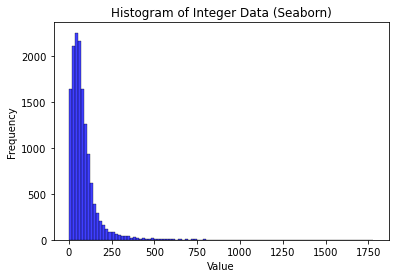

In [119]:
sns.histplot(converted_total, bins=100, kde=False, color='blue')
plt.title("Histogram of Integer Data (Seaborn)")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

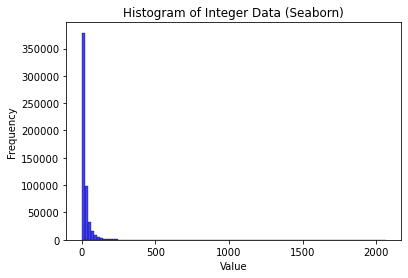

In [120]:
# Create a histogram using seaborn
sns.histplot(not_converted_total, bins=100, kde=False, color='blue')
plt.title("Histogram of Integer Data (Seaborn)")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

These distributions are *very* left skewed - let's make a function than can decide the correct statistical test to use.

In [110]:
#Function to handle various tests that should be used given the data
def difference_in_means_test(groupA, groupB, alpha, alternative):
    # Test for normaility
    shapiro_pv_A = stats.shapiro(groupA)[1]
    shapiro_pv_B = stats.shapiro(groupB)[1]
    
    if (shapiro_pv_A > alpha) & (shapiro_pv_B > alpha): # Distribution is normal
        # Test for homogeneity of variances
        levene_pv = stats.levene(groupA,groupB)[1]
        
        if levene_pv > alpha: 
            # Variances are homogenous, use standard t-test
            test = stats.ttest_ind(groupA, groupB, equal_var=True, alternative=alternative)
            test_type = "Standard t-test"
        else: 
            # Variances are heterogenous, use Welch's t-test
            test =  stats.ttest_ind(groupA, groupB, equal_var=False, alternative=alternative)
            test_type = "Welch's t-test"
            
    else: # Not a normal distribution so non-parametric test (Mann-Whitney U Test)
        test = stats.mannwhitneyu(groupA, groupB, alternative=alternative)
        test_type = "Mann-Whitney U Test"
    
    if test[1] < alpha:
        print("A " + test_type + " with Ha: \'" + alternative + "\' generated a p-value of " + str(test[1]) + ", therefore we reject the null hypothesis at the alpha = " + str(alpha) + " level of significance.")
    else:
        print("A " + test_type + " with Ha: \'" + alternative + "\' generated a p-value of " + str(test[1]) + ", therefore we fail to reject the null hypothesis at the alpha = " + str(alpha) + " level of significance.")
        
    return(test)

In [114]:
converted_total = ads_group[ads_group['converted'] == True]['total_ads']
not_converted_total = ads_group[ads_group['converted'] == False]['total_ads']

difference_in_means_test(converted_total, not_converted_total, .05, 'greater')

A Mann-Whitney U Test with Ha: 'greater' generated a p-value of 0.0, therefore we reject the null hypothesis at the alpha = 0.05 level of significance.


/Users/willthompson/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


MannwhitneyuResult(statistic=6788295318.5, pvalue=0.0)

### We have sufficient evidence to suggest that increasing the number of advertisements can generate a higher rate of conversion. But by exactly how much?

Let's do a logistic regression analysis on the total number of ads shown, and add another feature for $total\_ads^2$. Then, we'll be able to see if there's a diminishing effect at some point, perhaps if people get annoyed by the advertising.

First, a model with just the total_ads feature

In [180]:
logit_data = ads_group[['total_ads', 'converted']]
logit_data = sm.add_constant(logit_data)
logit_mod = sm.Logit(logit_data['converted'], logit_data[['total_ads', 'const']])

In [181]:
logit_res = logit_mod.fit()
print(logit_res.summary())

Optimization terminated successfully.
         Current function value: 0.110057
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               564577
Model:                          Logit   Df Residuals:                   564575
Method:                           MLE   Df Model:                            1
Date:                Mon, 28 Aug 2023   Pseudo R-squ.:                 0.07440
Time:                        19:16:39   Log-Likelihood:                -62136.
converged:                       True   LL-Null:                       -67130.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
total_ads      0.0102      0.000    101.089      0.000       0.010       0.010
const         -4.0422      0.

Our equation is the following: 


\begin{align*}
y &= 0.01016255 \cdot total\_ads - 4.04215779
\end{align*}


Thus, an increase in 1 advertisement seen by the viewer corresponds to roughly a 1% increase in the log-odds. How does this perform in practice?

In [152]:
X, y = ads_group[['total_ads']], ads_group['converted'].replace([True,False], [1,0])
clf = LogisticRegression(penalty='l2')
cv_scores = cross_val_score(clf, X, y, cv=5)

print("Mean cross-validated accuracy: " + str(cv_scores.mean()))

Mean cross-validated accuracy: 0.9640811285278597


In [272]:
X_train, X_test, y_train, y_test = train_test_split(ads_group[['total_ads']], ads_group['converted'].replace([True,False], [1,0]), test_size=.1, random_state=42)
lr = LogisticRegression(penalty='l2')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print("Accuracy: " + str(accuracy_score(y_test, y_pred)))
print("Confusion Matrix:\n" + str(confusion_matrix(y_test, y_pred)))

# TN      FP
# FN      TP

Accuracy: 0.9722979914272557
Confusion Matrix:
[[54876    84]
 [ 1480    18]]


This actually isn't very good, as the dataset is very imbalanced. The model is just predicting most of the examples as negative because that is the dominant class. Let's first add class weights.

In [274]:
lr_w = LogisticRegression(penalty='l2', class_weight='balanced')
lr_w.fit(X_train, y_train)
y_pred = lr_w.predict(X_test)
print("Accuracy: " + str(accuracy_score(y_test, y_pred)))
print("Confusion Matrix:\n" + str(confusion_matrix(y_test, y_pred)))

# TN      FP
# FN      TP

Accuracy: 0.8590102376988203
Confusion Matrix:
[[47448  7512]
 [  448  1050]]


We sacrificed some true negatives for some true positives, but in the process increased false positive rate by a lot. Let's see if relationships still hold when we downsample the majority class.

In [201]:
X_train_majority = ads_group[ads_group['converted'] == 0]
X_train_minority = ads_group[ads_group['converted'] == 1]
undersampling_size = len(X_train_minority)
X_train_majority_undersampled = resample(
    X_train_majority,
    n_samples=undersampling_size,
    random_state=42, 
)
downsampled = pd.concat([X_train_majority_undersampled, X_train_minority])
downsampled = downsampled.sample(frac=1)
downsampled

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
238225,1209559,ad,False,51,Sunday,15
584855,1178145,ad,False,6,Tuesday,8
276582,1258515,ad,True,26,Saturday,17
121860,1269742,ad,True,151,Tuesday,9
94148,1180394,ad,True,36,Tuesday,19
...,...,...,...,...,...,...
48759,1554752,ad,True,68,Friday,14
22524,1563462,ad,True,74,Wednesday,12
36193,1227367,ad,True,68,Wednesday,17
226424,1398029,ad,False,23,Monday,19


In [202]:
logit_data_ds = downsampled[['total_ads', 'converted']]
logit_data_ds = sm.add_constant(logit_data_ds)
logit_mod_ds = sm.Logit(logit_data_ds['converted'], logit_data_ds[['total_ads', 'const']])

In [204]:
logit_res_ds = logit_mod_ds.fit()
print(logit_res_ds.summary())

Optimization terminated successfully.
         Current function value: 0.537462
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:                28846
Model:                          Logit   Df Residuals:                    28844
Method:                           MLE   Df Model:                            1
Date:                Mon, 28 Aug 2023   Pseudo R-squ.:                  0.2246
Time:                        21:18:07   Log-Likelihood:                -15504.
converged:                       True   LL-Null:                       -19995.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
total_ads      0.0317      0.000     69.872      0.000       0.031       0.033
const         -1.3315      0.

The good news is that we can still be confident that the number of ads seen by a user has a positive effect on conversion rate, as the p-values are ~0 with equal numbered classes.

In [255]:
X_train, X_test, y_train, y_test = train_test_split(downsampled[['total_ads']], downsampled['converted'].replace([True,False], [1,0]), test_size=.2)
lr_ds = LogisticRegression(penalty='l2')
lr_ds.fit(X_train, y_train)
y_pred = lr_ds.predict(X_test)
print("Accuracy: " + str(accuracy_score(y_test, y_pred)))
print("Confusion Matrix:\n" + str(confusion_matrix(y_test, y_pred)))

# TN      FP
# FN      TP

Accuracy: 0.7790294627383015
Confusion Matrix:
[[2535  396]
 [ 879 1960]]


This seems much more robust, and our false negative/false positive count is no longer significantly outweighing our true negative count - in fact, it is the opposite. We now have predicted more true positives than false positives and false negatives combined. Let's now check if a quadratic term can provide further insight.

In [211]:
quad = downsampled[['total_ads','converted']].copy()
quad['total_ads_sq'] = quad['total_ads']**2
quad

,total_ads,converted,total_ads_sq
238225,51,False,2601
584855,6,False,36
276582,26,True,676
121860,151,True,22801
94148,36,True,1296
...,...,...,...
48759,68,True,4624
22524,74,True,5476
36193,68,True,4624
226424,23,False,529


In [213]:
logit_data_dsq = quad[['total_ads', 'total_ads_sq', 'converted']]
logit_data_dsq = sm.add_constant(logit_data_dsq)
logit_mod_dsq = sm.Logit(logit_data_dsq['converted'], logit_data_dsq[['total_ads', 'total_ads_sq', 'const']])

In [225]:
logit_res_dsq = logit_mod_dsq.fit()
print(logit_res_dsq.summary())

Optimization terminated successfully.
         Current function value: 0.519536
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:                28846
Model:                          Logit   Df Residuals:                    28843
Method:                           MLE   Df Model:                            2
Date:                Mon, 28 Aug 2023   Pseudo R-squ.:                  0.2505
Time:                        22:18:24   Log-Likelihood:                -14987.
converged:                       True   LL-Null:                       -19995.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
total_ads        0.0394      0.001     73.027      0.000       0.038       0.040
total_ads_sq -4.065e-05

In [281]:
X_train, X_test, y_train, y_test = train_test_split(quad[['total_ads', 'total_ads_sq']], quad['converted'].replace([True,False], [1,0]), test_size=.2)
lr_dsq = LogisticRegression(penalty='l2')
lr_dsq.fit(X_train, y_train)
y_pred = lr_dsq.predict(X_test)
print("Accuracy: " + str(accuracy_score(y_test, y_pred)))
print("Confusion Matrix:\n" + str(confusion_matrix(y_test, y_pred)))

# TN      FP
# FN      TP

Accuracy: 0.78526863084922
Confusion Matrix:
[[2459  432]
 [ 807 2072]]


In [288]:
lr_dsq.coef_

array([[ 3.95649262e-02, -4.37024575e-05]])

In [294]:
lr_dsq.intercept_

array([-1.50289818])

In [295]:
turning_point = (lr_dsq.coef_[0][0]) / (-2*lr_dsq.coef_[0][1])
turning_point

452.6624868387874

\begin{align*}
y &= 0.039565 \cdot total\_ads - 0.00004 \cdot total\_ads^2  - 1.5029
\end{align*}

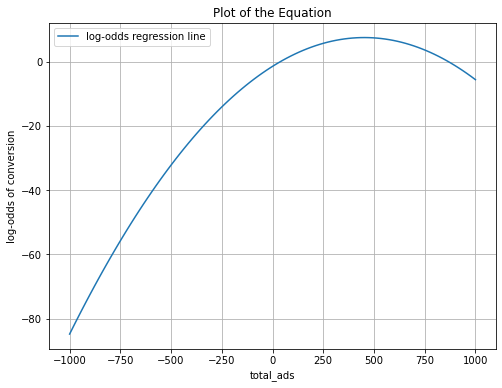

In [298]:
total_ads_values = np.linspace(-1000, 1000, 100)

y_values = lr_dsq.coef_[0][0] * total_ads_values + lr_dsq.coef_[0][1] * total_ads_values**2 - 1.5029

plt.figure(figsize=(8, 6))
plt.plot(total_ads_values, y_values, label='log-odds regression line')
plt.xlabel('total_ads')
plt.ylabel('log-odds of conversion')
plt.title('Plot of the Equation')
plt.legend()
plt.grid(True)
plt.show()

Using this model, we can interpret the following:\
Intercept: if no ads are shown, the odds are against someone converting (this makes sense).\
$total\_ads$: the log-odds of conversion increase by 3.9% with each additional ad. This translates to a ~4.0% ($e^.039 * 100%$) increase in likelihood of conversation with each additional ad.\
$total\_ads^2$: once the number of ads shown reaches 452, the log-odds (and odds as well) of conversion begin to decrease.

Conclusion:\
Our goal was to observe whether showing ads is a successful course of action in generating conversion, and if so, how much? Ultimately, we achieved answers to both questions. The evidence that ads generate a higher rate of conversion is very strong as evidenced by our significance test. We then discovered that there is a signficant positive relationship to the number of ads shown on conversion as well. By squaring the total_ads for a new feature in the logistic regression model, we discovered that the marginal effect of showing addtional ads on conversion turns negative at a certain point. There is still a lot of variance left in the model as we did not do any hyperparameter tuning or feature engineering, thus the true values we should base our business decisions and cost optimizations on should not be decided by this analysis alone. However, we can conclude this analysis with confidence that ads signficantly increase conversion, and there lies a point where showing additional ads does not create any additional benefit.